# Optimizers

In order to improve computational efficiency, gradient-based optimization in deep
learning does not usually rely on the full dataset at each update step. Instead, it
**employs** stochastic gradient descent (SGD), which uses small subsets of the data known
as mini-batches. This strategy introduces stochasticity into the optimization process,
reduces computational cost per update, and helps escape problematic regions of the loss
landscape, such as saddle points, where the gradient vanishes without corresponding to a
true minimum.

Basic gradient descent can be inefficient or unstable in certain scenarios, particularly
when the loss surface exhibits strong anisotropy or narrow valleys. For this reason,
several variants have been developed to improve convergence speed and robustness. Among
the most widely used are Momentum, RMSprop, and Adam, all of which build on the idea of
adapting the update step based on past gradient information.

Momentum augments SGD with an inertia term that accumulates gradient information over
time, thereby smoothing the updates. It is defined by the following equations:

$$
v_t = \beta v_{t-1} + (1 - \beta)\,\nabla_\theta \mathcal{L}(\theta_t),
$$

$$
\theta_{t+1} = \theta_t - \eta\,v_t,
$$

where $v_t$ denotes the accumulated "velocity", $\beta \in [0, 1)$ is a decay
coefficient, and $\eta$ is the learning rate. In practice, $\beta$ is often set to $0.9$.
This mechanism reduces oscillations in directions of high curvature and accelerates
convergence along narrow valleys by integrating information across multiple steps instead
of relying solely on the current gradient.

RMSprop is an adaptive learning rate method that rescales the gradients by a moving
average of their squared values. It is defined as:

$$
s_t = \rho s_{t-1} + (1 - \rho)\left(\nabla_\theta \mathcal{L}(\theta_t)\right)^2,
$$

$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{s_t + \epsilon}}\,\nabla_\theta \mathcal{L}(\theta_t),
$$

where $\rho \approx 0.9$ and $\epsilon \approx 10^{-8}$ is a small constant introduced to
avoid division by zero. In this formulation, parameters associated with consistently
large gradients are updated with smaller steps, while those associated with small
gradients receive relatively larger steps. This adaptive behaviour improves the stability
of training and makes the optimizer more robust to poorly scaled loss landscapes.

Adam (Adaptive Moment Estimation) combines the advantages of Momentum and RMSprop by
maintaining both an exponential moving average of the gradients (first moment) and an
exponential moving average of their squared values (second moment). The algorithm
proceeds in four stages.

First, it computes the exponentially weighted moving average of the gradients (first
moment):

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)\,\nabla_\theta \mathcal{L}(\theta_t).
$$

Second, it computes the exponentially weighted moving average of the squared gradients
(second moment):

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2)\,\left(\nabla_\theta \mathcal{L}(\theta_t)\right)^2.
$$

Third, it performs a bias correction step to compensate for the initialization of $m_t$
and $v_t$ at zero:

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}.
$$

Finally, it updates the parameters using the bias-corrected moments:

$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon}\,\hat{m}_t.
$$

Typical recommended values are $\beta_1 = 0.9$, $\beta_2 = 0.999$, and
$\epsilon = 10^{-8}$. Adam is widely adopted in deep learning due to its fast
convergence, numerical stability, and robustness to suboptimal hyperparameter
configurations. It adapts the learning rate per parameter based on both the magnitude and
the variance of the gradients, while also leveraging momentum-like smoothing.

## Simple 1D Function Optimization

As an illustrative example, the following implementation compares these optimizers on the
simple one-dimensional test function $f(\theta) = \theta^2$, whose global minimum is
located at $\theta = 0$. In this setting, all optimizers start from an initial value
$\theta = 5$ and attempt to reduce the loss. Although each algorithm follows a different
trajectory through parameter space, they all tend toward the global minimum at
$\theta = 0$.

In [1]:
# 3pps
import numpy as np


# Loss function and gradient
loss = lambda theta: theta**2
grad = lambda theta: 2 * theta

# Initial value
theta_init = 5.0


# Stochastic Gradient Descent (SGD)
def sgd(theta, grad, eta=0.1, steps=20):
    for t in range(steps):
        theta -= eta * grad(theta)
    return theta


# Momentum
def momentum(theta, grad, eta=0.1, beta=0.9, steps=20):
    v = 0
    for t in range(steps):
        v = beta * v + (1 - beta) * grad(theta)
        theta -= eta * v
    return theta


# RMSprop
def rmsprop(theta, grad, eta=0.1, rho=0.9, eps=1e-8, steps=20):
    s = 0
    for t in range(steps):
        g = grad(theta)
        s = rho * s + (1 - rho) * g**2
        theta -= eta / (np.sqrt(s) + eps) * g
    return theta


# Adam
def adam(theta, grad, eta=0.1, beta1=0.9, beta2=0.999, eps=1e-8, steps=20):
    m, v = 0, 0
    for t in range(1, steps + 1):
        g = grad(theta)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        theta -= eta / (np.sqrt(v_hat) + eps) * m_hat
    return theta


print("SGD:", sgd(theta_init, grad))
print("Momentum:", momentum(theta_init, grad))
print("RMSprop:", rmsprop(theta_init, grad))
print("Adam:", adam(theta_init, grad))

SGD: 0.057646075230342354
Momentum: -1.3533566908039512
RMSprop: 2.451835572498659
Adam: 3.060338887144194


## Neural Network Training with Different Optimizers

The following example demonstrates how different optimizers perform when training a small
neural network on the circle dataset used in the regularization examples:

Training with SGD...
  Final train loss: 0.6999
  Final test loss: 0.6991

Training with Momentum...
  Final train loss: 0.6910
  Final test loss: 0.6915

Training with RMSprop...
  Final train loss: 0.2045
  Final test loss: 0.1903

Training with Adam...
  Final train loss: 0.0149
  Final test loss: 0.0180



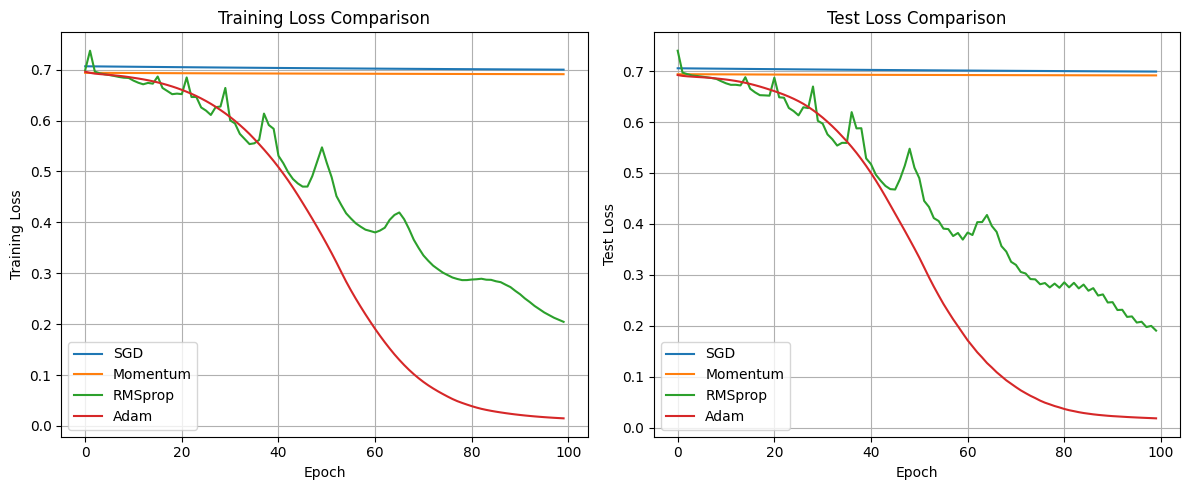

In [2]:
# 3pps
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from torch import nn


# Generate and prepare data
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1)
y_test = torch.from_numpy(y_test.astype(np.float32)).unsqueeze(1)


# Simple neural network
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)


# Training function
def train_with_optimizer(optimizer_name, learning_rate=0.01, num_epochs=100):
    model = BinaryClassifier()
    loss_fn = nn.BCEWithLogitsLoss()

    # Select optimizer
    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "Momentum":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        loss = loss_fn(logits, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses


# Compare optimizers
optimizers = ["SGD", "Momentum", "RMSprop", "Adam"]
results = {}

for opt_name in optimizers:
    print(f"Training with {opt_name}...")
    train_loss, test_loss = train_with_optimizer(opt_name, learning_rate=0.01)
    results[opt_name] = {"train": train_loss, "test": test_loss}
    print(f"  Final train loss: {train_loss[-1]:.4f}")
    print(f"  Final test loss: {test_loss[-1]:.4f}\n")

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for opt_name in optimizers:
    plt.plot(results[opt_name]["train"], label=opt_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for opt_name in optimizers:
    plt.plot(results[opt_name]["test"], label=opt_name)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()